# Convolutional deep autoencoder on mnist

This is an experiment training a convolutional autoencoder on the MNIST database using keras.

This is heavily inspired by [this blog article](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/), but it uses keras instead of Lasagne.

We experiment with 10 and 2 neurons in the representation layer (the deepest layer).

In [1]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu1,floatX=float32'
#os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=gpu,floatX=float32'
#os.environ['THEANO_FLAGS']='device=gpu0'

In [2]:
import theano
print theano.config.device

Couldn't import dot_parser, loading of dot files will not be possible.
gpu1


Using gpu device 1: Tesla M2075


In [3]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
import keras.layers.containers as containers
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, AutoEncoder, Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import ActivityRegularizer
from keras.utils.model_utils import print_layer_shapes

In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
%matplotlib inline

In [6]:
# Some utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
    
def compare_input_reconstruction(input_img, rec_img, repr_activation, clsname='', fig=None):
    """
    Utility function to show input digit and autoencoder reconstruction
    
    Args:
        input_img: A 2D input image
        rec_img: The 2D reconstructed image
        repr_activation: The activation of the representation neurons
    """
    if fig is None:
        fig = pl.figure(figsize=(15, 5))
    ax = pl.subplot(131)
    ax.set_title('input image (class = %s)' % clsname)
    nice_imshow(ax, input_img, vmin=0, vmax=1, cmap=cm.binary)
     
    ax = pl.subplot(132)
    ax.set_title('reconstruction')
    nice_imshow(ax, rec_img, vmin=0, vmax=1, cmap=cm.binary)
    
    ax = pl.subplot(133)
    
    bar_centers = np.arange(len(repr_activation))
    ax.set_title('representation neurons activation')
    ax.bar(bar_centers, repr_activation, width=0.8, align='center')
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    
    pl.tight_layout()

In [7]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train, y_train = X_train[:10000], y_train[:10000]

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


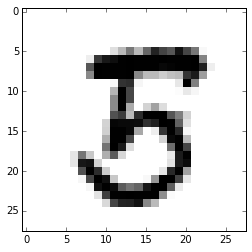

In [8]:
i = 4600
pl.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [9]:
X_train.shape

(60000, 1, 28, 28)

In [10]:
import theano.tensor as T

class UnPooling2D(Layer):
    """A 2D Repeat layer"""
    def __init__(self, poolsize=(2, 2)):
        super(UnPooling2D, self).__init__()
        self.input = T.tensor4()
        self.poolsize = poolsize

    def get_output(self, train):
        X = self.get_input(train)
        s1 = self.poolsize[0]
        s2 = self.poolsize[1]
        output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        return output

    def get_config(self):
        return {"name":self.__class__.__name__,
            "poolsize":self.poolsize}

Autoencoder with two convolutional layers and 10 neurons at the representation (deepest) layer. We use linear activation everywhere.

## 10 representation neurons

In [11]:
## Note about intermediate functions and print_layer_shapes:
# If you move print_layer_shapes or the decode function definition past
# the definition of the global model, they will fail.
# This is because adding our decoder model to the global model
# will cause it to be linked to the encoder and therefore get_input
# will return the input of the global model and NOT of the decoder
# itself.
# TODO: There must be a cleaner way

# - Build the encoder pipeline
encoder = models.Sequential()
encoder.add(Convolution2D(32, 1, 5, 5, border_mode='valid')) 
encoder.add(MaxPooling2D(poolsize=(2, 2)))
encoder.add(Convolution2D(32, 32, 3, 3, border_mode='valid'))
encoder.add(MaxPooling2D(poolsize=(2, 2)))  # after this, we have 32 * 12 * 12
encoder.add(Flatten())
encoder.add(Dense(32*5*5, 128))
encoder.add(Dense(128, 10))

print('-- encoder')
print_layer_shapes(encoder, (1, 1, 28, 28))

encode = theano.function([encoder.get_input(train=False)], encoder.get_output(train=False))

# - Decoder
decoder = models.Sequential()
decoder.add(Dense(10, 128))
decoder.add(Dense(128, 32*5*5))
decoder.add(Reshape(32, 5, 5))
decoder.add(UnPooling2D(poolsize=(2, 2)))
decoder.add(Convolution2D(32, 32, 3, 3, border_mode='full'))
decoder.add(UnPooling2D(poolsize=(2, 2)))
decoder.add(Convolution2D(1, 32, 5, 5, border_mode='full'))

# Note that if you move that after the chain, this will fail because of input
print('-- decoder')
print_layer_shapes(decoder, (1, 10))

decode = theano.function([decoder.get_input(train=False)], decoder.get_output(train=False))

# - Chain everything to build model
model = models.Sequential()

# Add a noise layer to get a denoising autoencoder
inlayer = GaussianNoise(sigma=0.3)
# This doesn't work without this because GaussianNoise doesn't know what
# kind of input it will receive. Oddly enough if we don't use containers
# and directly build a single model, we don't have to specify this...
inlayer.input = T.tensor4()

model.add(inlayer)
model.add(encoder)
model.add(decoder)

print('-- model')
print_layer_shapes(model, (1, 1, 28, 28))

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
model.compile(loss='mean_squared_error', optimizer='adadelta')

-- encoder
input shape :  (1, 1, 28, 28)
shape after Convolution2D : [ 1 32 24 24]
shape after MaxPooling2D : [ 1 32 12 12]
shape after Convolution2D : [ 1 32 10 10]
shape after MaxPooling2D : [ 1 32  5  5]
shape after Flatten : [  1 800]
shape after Dense : [  1 128]
shape after Dense : [ 1 10]
-- decoder
input shape :  (1, 10)
shape after Dense : [  1 128]
shape after Dense : [  1 800]
shape after Reshape : [ 1 32  5  5]
shape after UnPooling2D : [ 1 32 10 10]
shape after Convolution2D : [ 1 32 12 12]
shape after UnPooling2D : [ 1 32 24 24]
shape after Convolution2D : [ 1  1 28 28]
-- model
input shape :  (1, 1, 28, 28)
shape after GaussianNoise : [ 1  1 28 28]
shape after Sequential : [ 1 10]
shape after Sequential : [ 1  1 28 28]


A theano function to get the representation of a given input (without reconstructing it)

X_enc.shape :  (5, 10)
X_rec.shape :  (2, 1, 28, 28)


<matplotlib.colorbar.Colorbar instance at 0x7f67e87986c8>

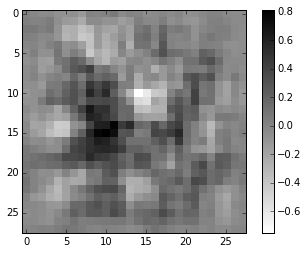

In [12]:
# Of course we'll get random results here because this is with an untrained autoencoder
X_enc = encode(X_train[0:5])
print("X_enc.shape : ", X_enc.shape)

X_rec = decode(np.random.random((2, 10)).astype(np.float32))
print("X_rec.shape : ", X_rec.shape)

X_pred = model.predict(X_train[0:5])

pl.imshow(X_pred[0].squeeze(), interpolation='nearest', cmap=cm.binary)
pl.colorbar()

Ok, so let's train it

In [13]:
nb_epoch = 10
batch_size = 128

history = model.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 0
60000/60000 [==============================] - 65s - loss: 0.0571 - acc: 0.1399 - val_loss: 0.0398 - val_acc: 0.1635
Epoch 1
60000/60000 [==============================] - 65s - loss: 0.0390 - acc: 0.1699 - val_loss: 0.0426 - val_acc: 0.1674
Epoch 2
60000/60000 [==============================] - 65s - loss: 0.0378 - acc: 0.1742 - val_loss: 0.0371 - val_acc: 0.1876
Epoch 3
60000/60000 [==============================] - 65s - loss: 0.0373 - acc: 0.1797 - val_loss: 0.0372 - val_acc: 0.1946
Epoch 4
60000/60000 [==============================] - 65s - loss: 0.0370 - acc: 0.1859 - val_loss: 0.0369 - val_acc: 0.1923
Epoch 5
60000/60000 [==============================] - 65s - loss: 0.0367 - acc: 0.1896 - val_loss: 0.0371 - val_acc: 0.1951
Epoch 6
60000/60000 [==============================] - 66s - loss: 0.0366 - acc: 0.1951 - val_loss: 0.0415 - val_acc: 0.1840
Epoch 7
60000/60000 [==============================] - 65s - loss: 0.0365 -

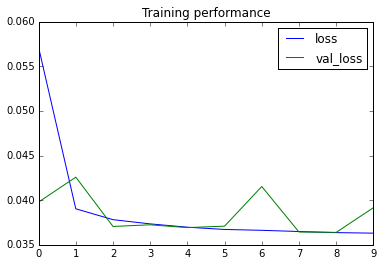

In [14]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

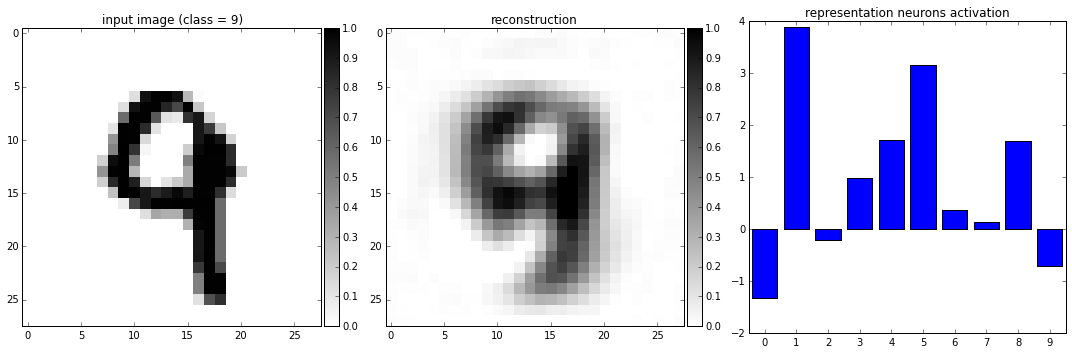

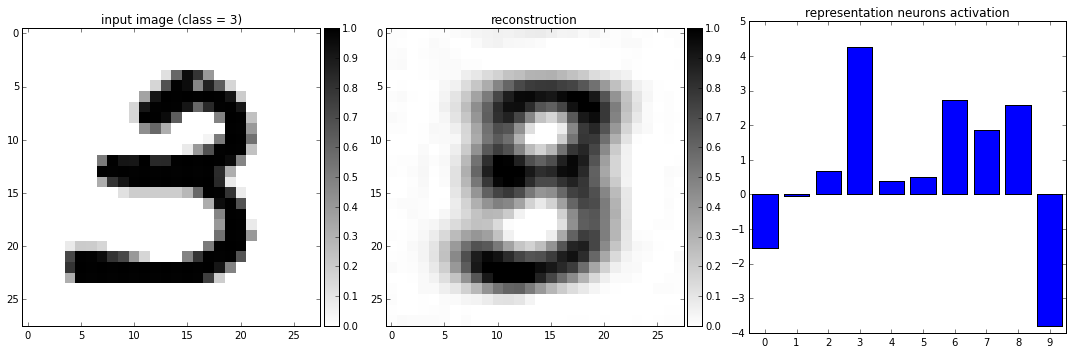

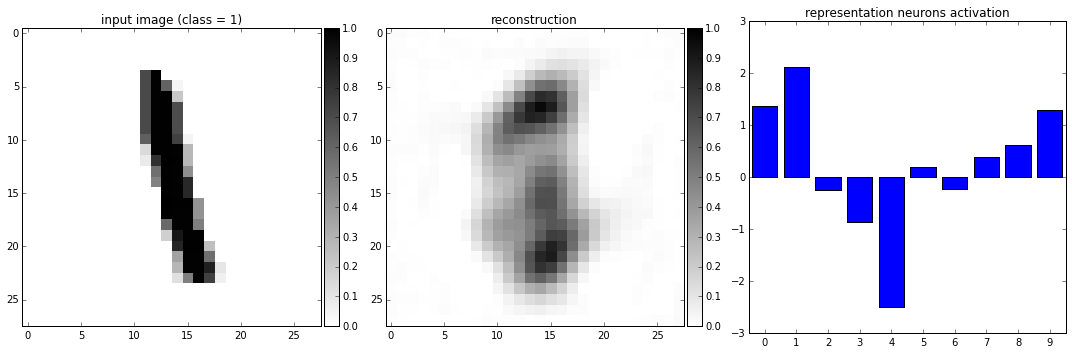

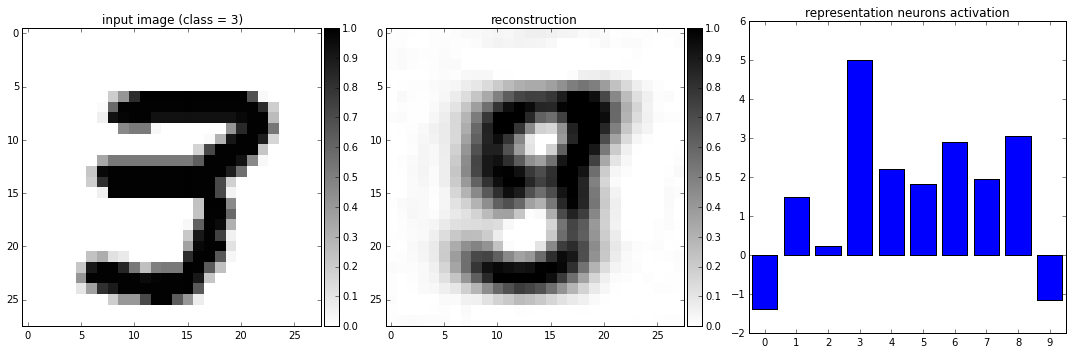

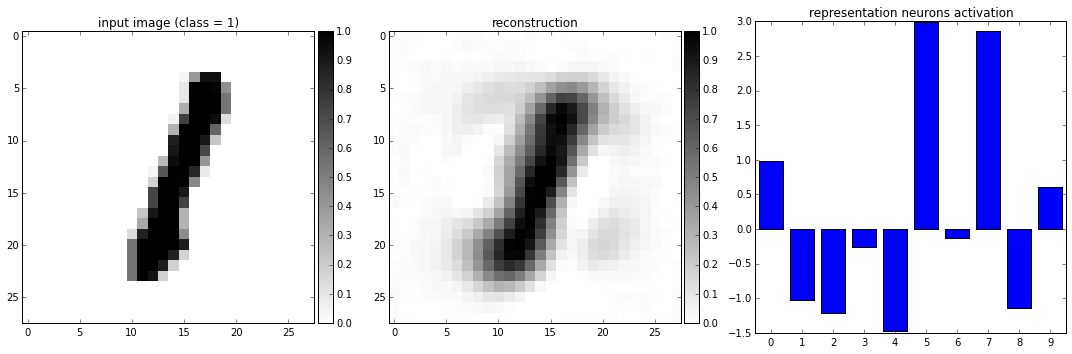

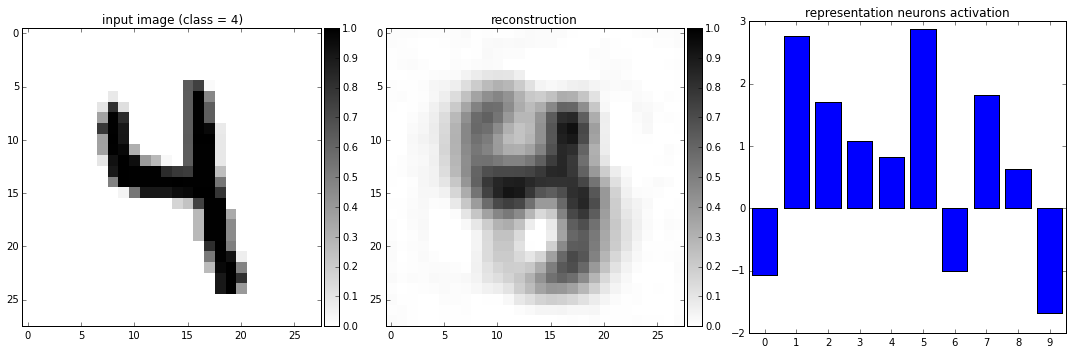

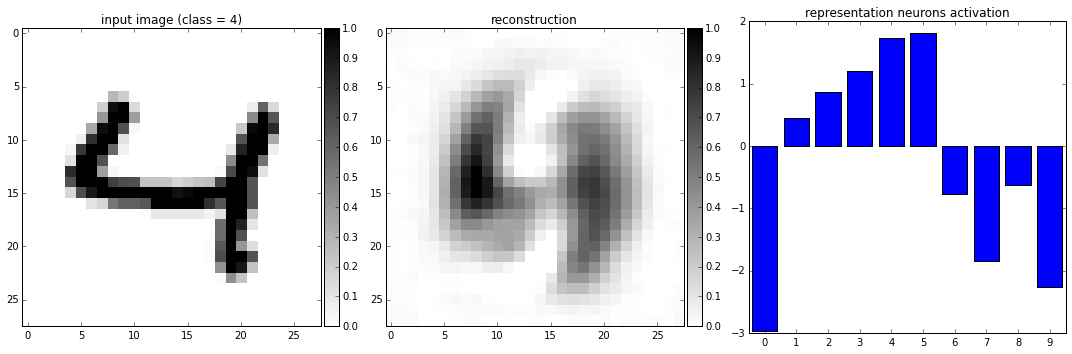

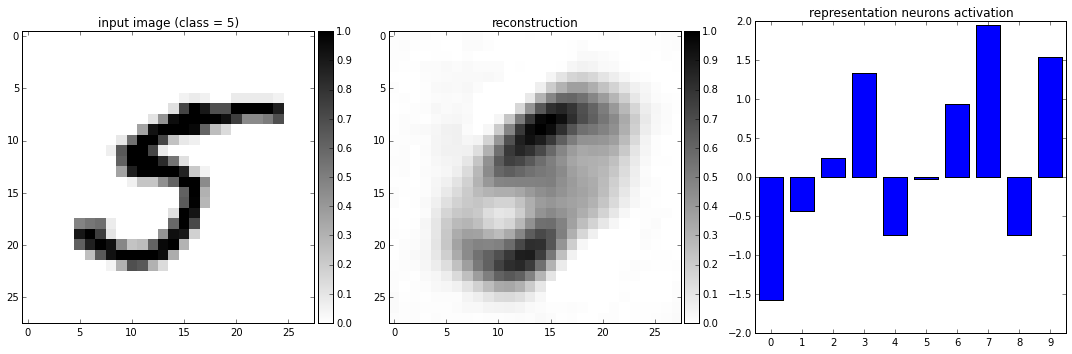

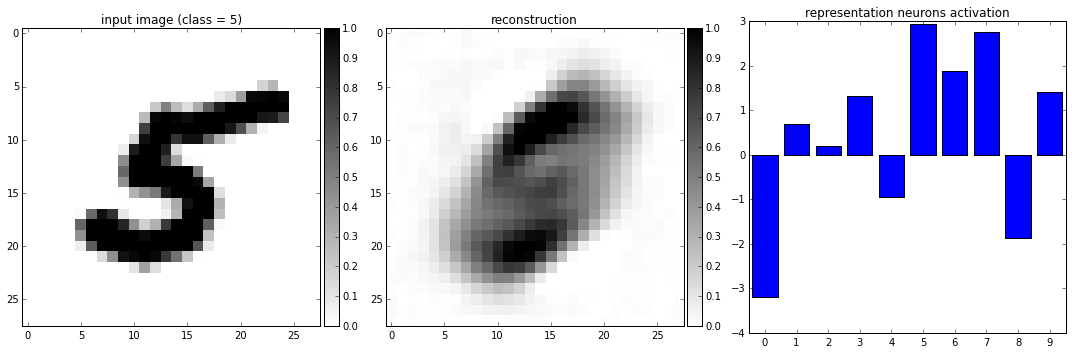

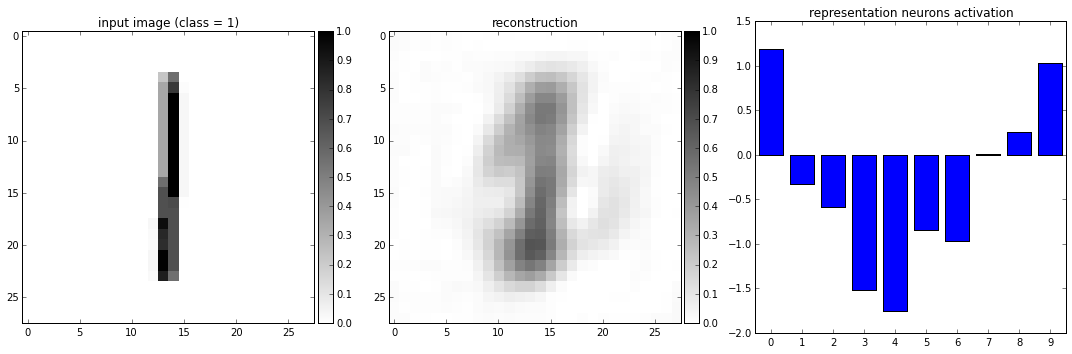

In [15]:
import random
indices = np.array(random.sample(xrange(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = model.predict(X)
X_repr = encode(X)

for i in xrange(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

Now, for each class of digit, we can plot the average activation of each representation neuron. Unfortunately, as we see below (based on the error bars), it varies a lot.

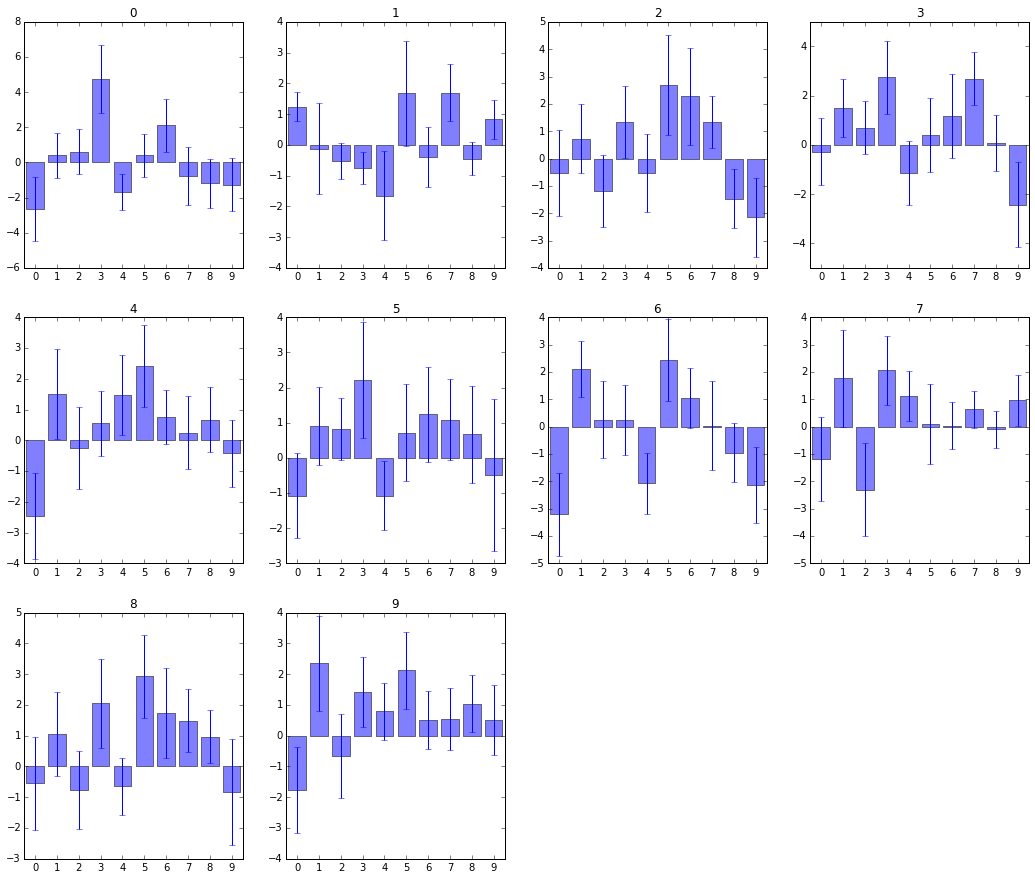

In [17]:
X_test_repr = encode(X_test)

# For each label, plot an histogram of the encoding of
# all test example that belong to said label

pl.figure(figsize=(18, 15))
for label in np.unique(y_test):
    pl.subplot(3, 4, label + 1)
    pl.title(label)
    encodings = X_test_repr[y_test == label]
    
    # encodings is nexamples x 10
    means = np.mean(encodings, axis=0)
    stds = np.std(encodings, axis=0)
    
    bar_centers = np.arange(X_test_repr.shape[1])
    pl.bar(bar_centers, means, width=0.8, align='center', yerr=stds, alpha=0.5)
    pl.xticks(bar_centers, bar_centers)
    pl.xlim((-0.5, bar_centers[-1] + 0.5))
    #pl.ylim((0, 0.3))

By activating a single representation neuron at a time, we can get our decoder to generate parts of digits

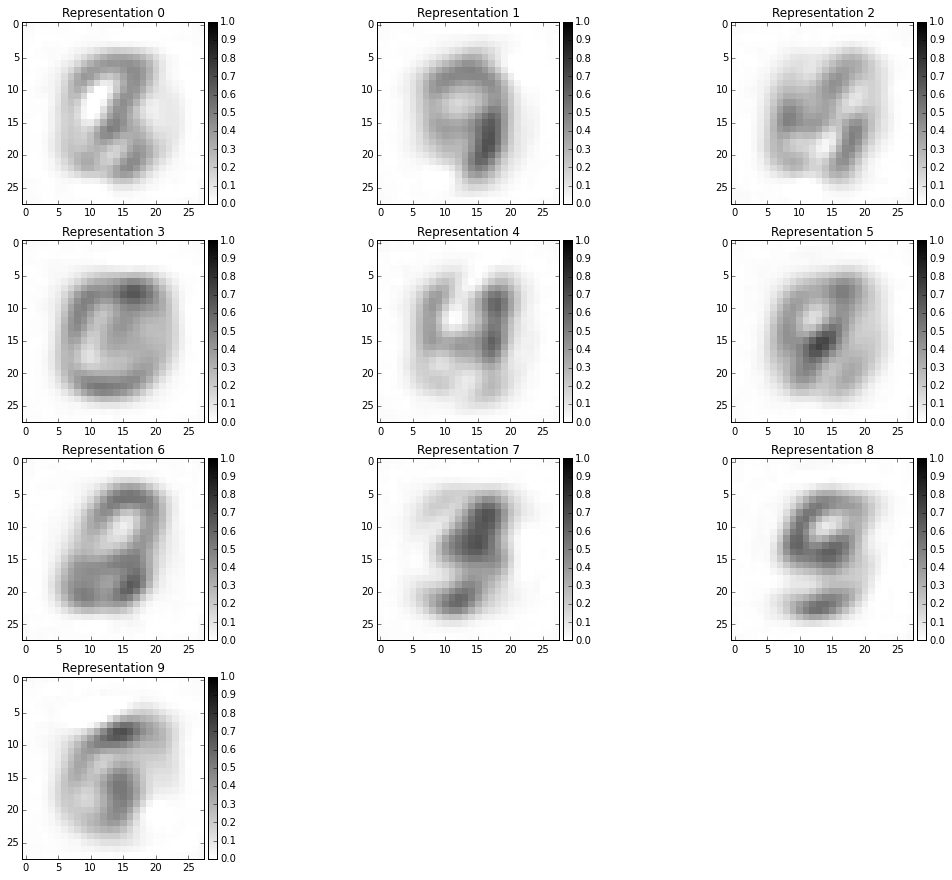

In [18]:
pl.figure(figsize=(18, 15))
for r in xrange(10):
    pl.subplot(4, 3, r + 1)
    X_enc = np.zeros((1, 10), dtype=np.float32)
    X_enc[:,r] = 2
    X_rec = decode(X_enc)
    
    pl.title('Representation %d' % r)
    nice_imshow(pl.gca(), X_rec.squeeze(), vmin=0, vmax=1, cmap=cm.binary)

## With only 2 representation neurons

If we use only 2 representation neurons, the advantage is that we get make a 2D scatter plot of our data. The autoencoder performs dimensionality reduction.

In [19]:
## Note about intermediate functions and print_layer_shapes:
# If you move print_layer_shapes or the decode function definition past
# the definition of the global model, they will fail.
# This is because adding our decoder model to the global model
# will cause it to be linked to the encoder and therefore get_input
# will return the input of the global model and NOT of the decoder
# itself.
# TODO: There must be a cleaner way

# - Build the encoder pipeline
encoder = models.Sequential()
encoder.add(Convolution2D(32, 1, 5, 5, border_mode='valid')) 
encoder.add(MaxPooling2D(poolsize=(2, 2)))
encoder.add(Convolution2D(32, 32, 3, 3, border_mode='valid'))
encoder.add(MaxPooling2D(poolsize=(2, 2)))  # after this, we have 32 * 12 * 12
encoder.add(Flatten())
encoder.add(Dense(32*5*5, 128))
encoder.add(Dense(128, 2))

print('-- encoder')
print_layer_shapes(encoder, (1, 1, 28, 28))

encode = theano.function([encoder.get_input(train=False)], encoder.get_output(train=False))

# - Decoder
decoder = models.Sequential()
decoder.add(Dense(2, 128))
decoder.add(Dense(128, 32*5*5))
decoder.add(Reshape(32, 5, 5))
decoder.add(UnPooling2D(poolsize=(2, 2)))
decoder.add(Convolution2D(32, 32, 3, 3, border_mode='full'))
decoder.add(UnPooling2D(poolsize=(2, 2)))
decoder.add(Convolution2D(1, 32, 5, 5, border_mode='full'))

# Note that if you move that after the chain, this will fail because of input
print('-- decoder')
print_layer_shapes(decoder, (1, 2))

decode = theano.function([decoder.get_input(train=False)], decoder.get_output(train=False))

# - Chain everything to build model
model = models.Sequential()

# Add a noise layer to get a denoising autoencoder
inlayer = GaussianNoise(sigma=0.3)
# This doesn't work without this because GaussianNoise doesn't know what
# kind of input it will receive. Oddly enough if we don't use containers
# and directly build a single model, we don't have to specify this...
inlayer.input = T.tensor4()

model.add(inlayer)
model.add(encoder)
model.add(decoder)

print('-- model')
print_layer_shapes(model, (1, 1, 28, 28))

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
model.compile(loss='mean_squared_error', optimizer='adadelta')

-- encoder
input shape :  (1, 1, 28, 28)
shape after Convolution2D : [ 1 32 24 24]
shape after MaxPooling2D : [ 1 32 12 12]
shape after Convolution2D : [ 1 32 10 10]
shape after MaxPooling2D : [ 1 32  5  5]
shape after Flatten : [  1 800]
shape after Dense : [  1 128]
shape after Dense : [1 2]
-- decoder
input shape :  (1, 2)
shape after Dense : [  1 128]
shape after Dense : [  1 800]
shape after Reshape : [ 1 32  5  5]
shape after UnPooling2D : [ 1 32 10 10]
shape after Convolution2D : [ 1 32 12 12]
shape after UnPooling2D : [ 1 32 24 24]
shape after Convolution2D : [ 1  1 28 28]
-- model
input shape :  (1, 1, 28, 28)
shape after GaussianNoise : [ 1  1 28 28]
shape after Sequential : [1 2]
shape after Sequential : [ 1  1 28 28]


In [20]:
nb_epoch = 10
batch_size = 128

history = model.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, validation_data=(X_test, X_test))
score = model.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Train on 60000 samples, validate on 10000 samples
Epoch 0
60000/60000 [==============================] - 68s - loss: 0.0883 - acc: 0.0857 - val_loss: 0.0595 - val_acc: 0.0988
Epoch 1
60000/60000 [==============================] - 66s - loss: 0.0576 - acc: 0.1014 - val_loss: 0.0582 - val_acc: 0.1115
Epoch 2
60000/60000 [==============================] - 67s - loss: 0.0570 - acc: 0.1064 - val_loss: 0.0592 - val_acc: 0.1100
Epoch 3
60000/60000 [==============================] - 67s - loss: 0.0568 - acc: 0.1110 - val_loss: 0.0578 - val_acc: 0.1353
Epoch 4
60000/60000 [==============================] - 66s - loss: 0.0567 - acc: 0.1149 - val_loss: 0.0585 - val_acc: 0.1199
Epoch 5
60000/60000 [==============================] - 66s - loss: 0.0566 - acc: 0.1185 - val_loss: 0.0591 - val_acc: 0.1210
Epoch 6
60000/60000 [==============================] - 66s - loss: 0.0566 - acc: 0.1210 - val_loss: 0.0576 - val_acc: 0.1486
Epoch 7
60000/60000 [==============================] - 66s - loss: 0.0565 -

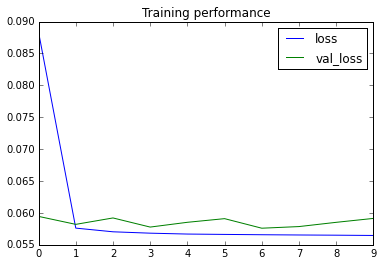

In [21]:
pl.figure()
pl.title('Training performance')
pl.plot(history.epoch, history.history['loss'], label='loss')
pl.plot(history.epoch, history.history['val_loss'], label='val_loss')
pl.legend()

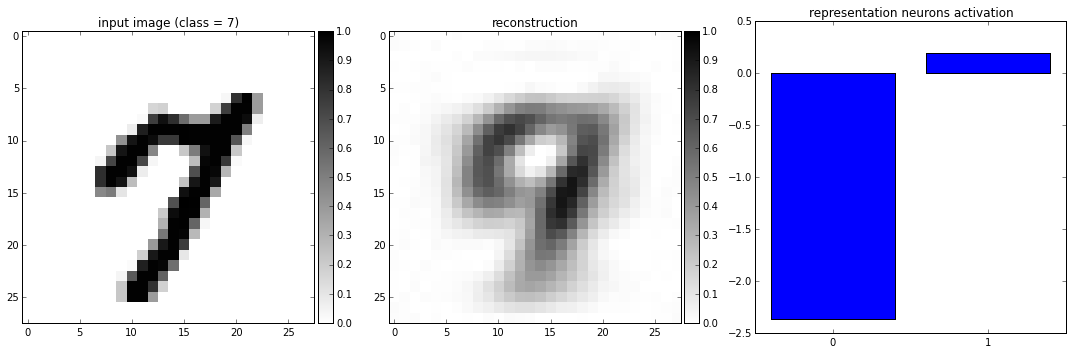

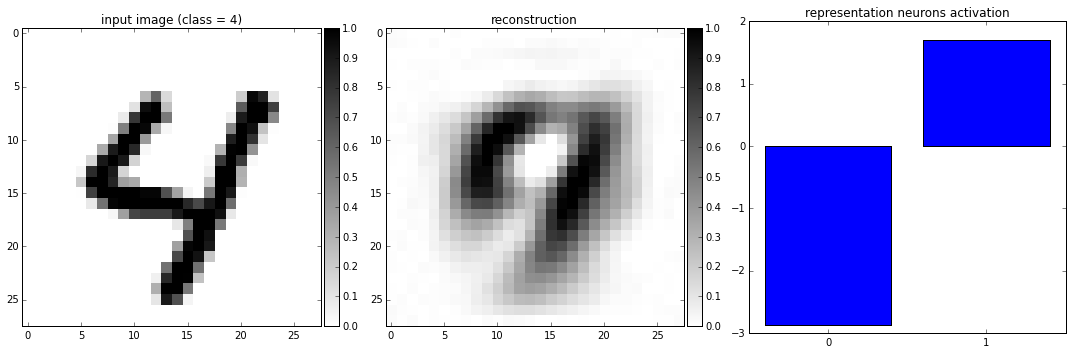

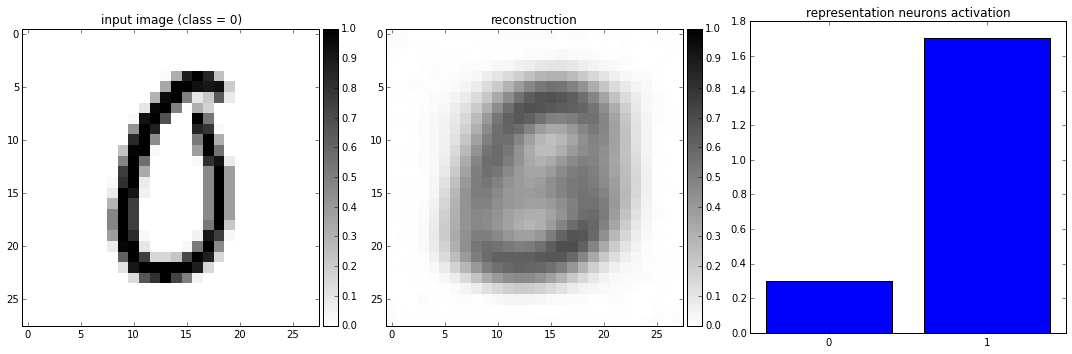

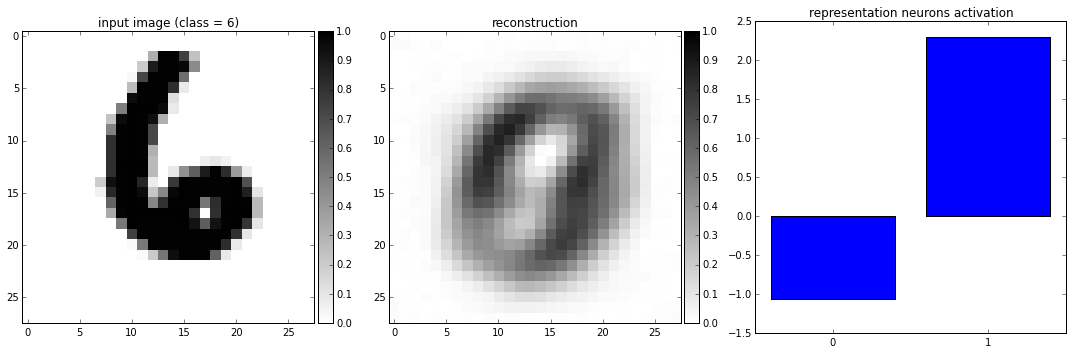

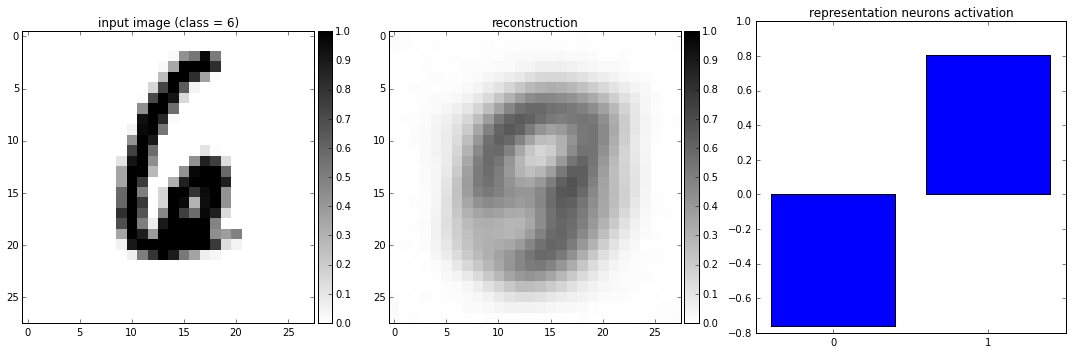

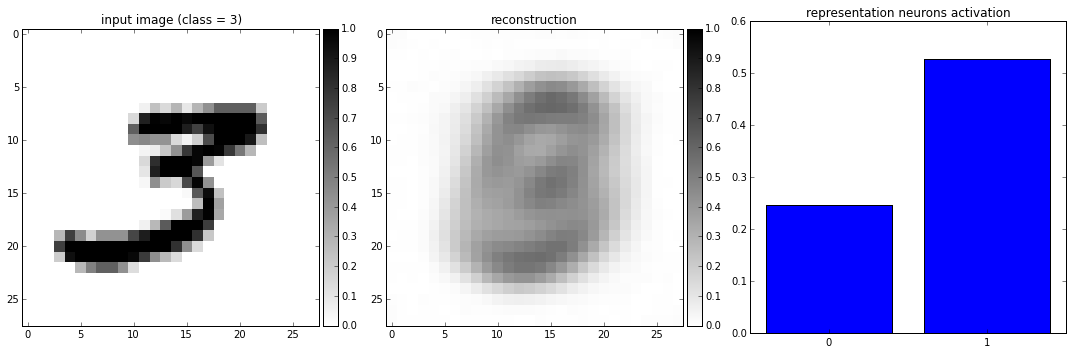

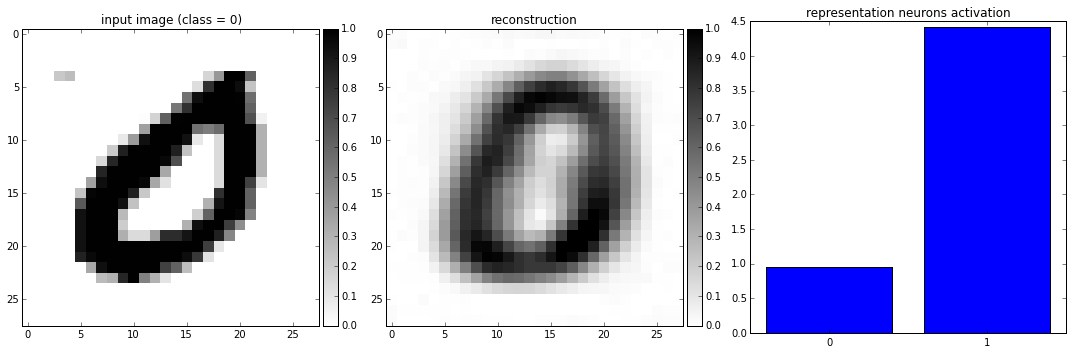

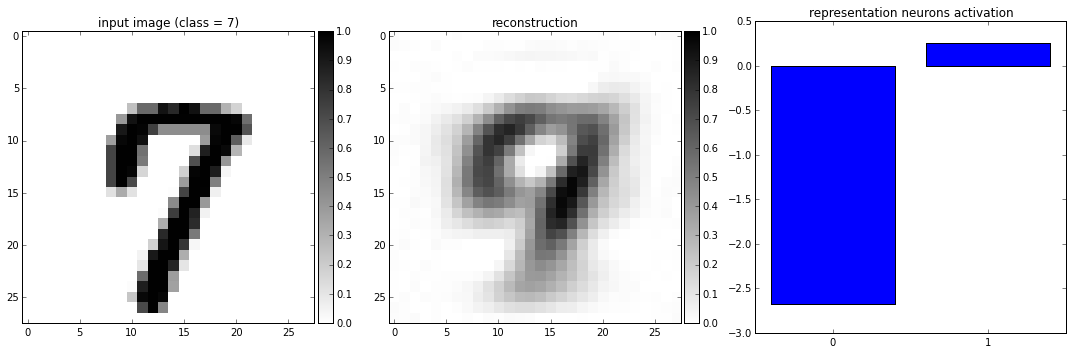

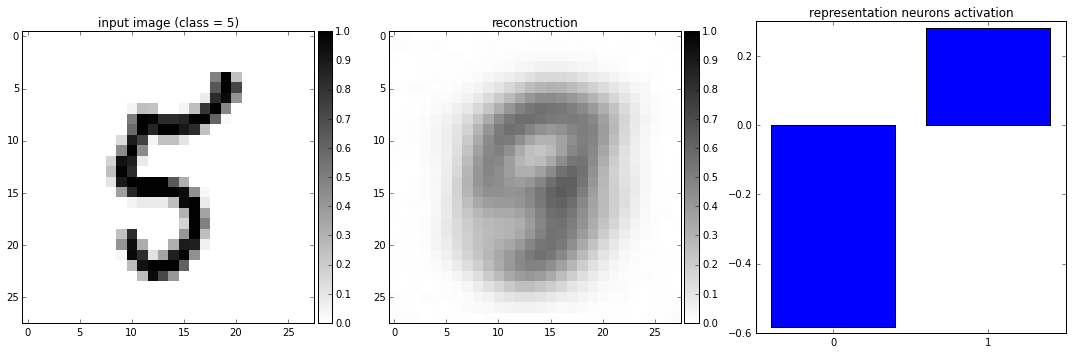

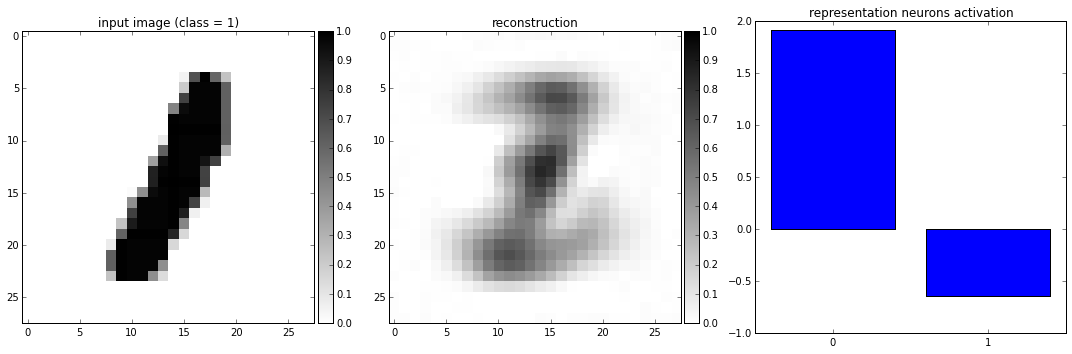

In [22]:
import random
indices = np.array(random.sample(xrange(X_test.shape[0]), 10))
X = X_test[indices]
X_pred = model.predict(X)
X_repr = encode(X)

for i in xrange(X.shape[0]):
    compare_input_reconstruction(X[i].squeeze(), X_pred[i].squeeze(), X_repr[i],
                                clsname=y_test[indices[i]])

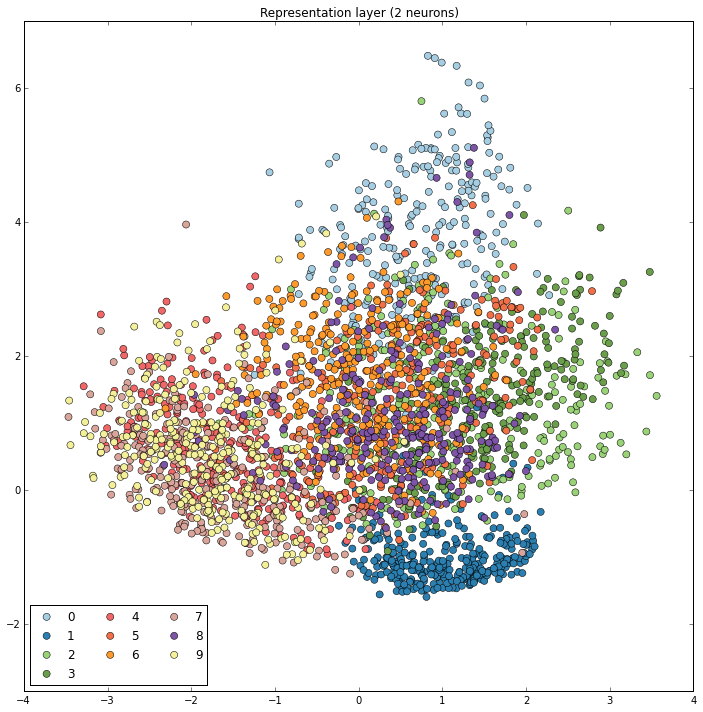

In [24]:
X_test_repr = encode(X_test)

import matplotlib as mpl

indices = random.sample(xrange(X_test_repr.shape[0]), 3000)
points = X_test_repr[indices]
labels = y_test[indices]

norm = mpl.colors.Normalize(vmin=0, vmax=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.Paired)
colors = m.to_rgba(labels)

pl.figure(figsize=(12, 12))
pl.title('Representation layer (2 neurons)')

scatters = []
for lid in np.unique(labels):
    mask = labels == lid
    sc = pl.scatter(points[mask, 0], points[mask, 1], c=colors[mask], linewidth=0.5, s=50)
    scatters.append(sc)
pl.legend(scatters, np.arange(10), scatterpoints=1, loc='lower left', ncol=3, fontsize=12)